#                            **Advanced Interpretable Diagnosis of Alzheimer’s Disease**

### Alzheimer's disease is a progressive neurological disorder that causes brain cells to degenerate and die. It is the most common cause of dementia, a condition characterized by a decline in cognitive abilities such as memory, reasoning, and social skills.



# Import Libraries

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Input, Reshape, multiply
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import os



In [37]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, Reshape, multiply
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define Paths and Hyperparameters

In [ ]:
# Dataset directory
dataset_dir = r"C:\Users\Akshay\Downloads\mlp\balanced_dataset"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
batch_size = 32
num_epochs = 50
learning_rate = 0.001
n_estimators = 100  # For Random Forest classifier
reduction_ratio = 16  # SE Block reduction ratio


# Images of Different classess

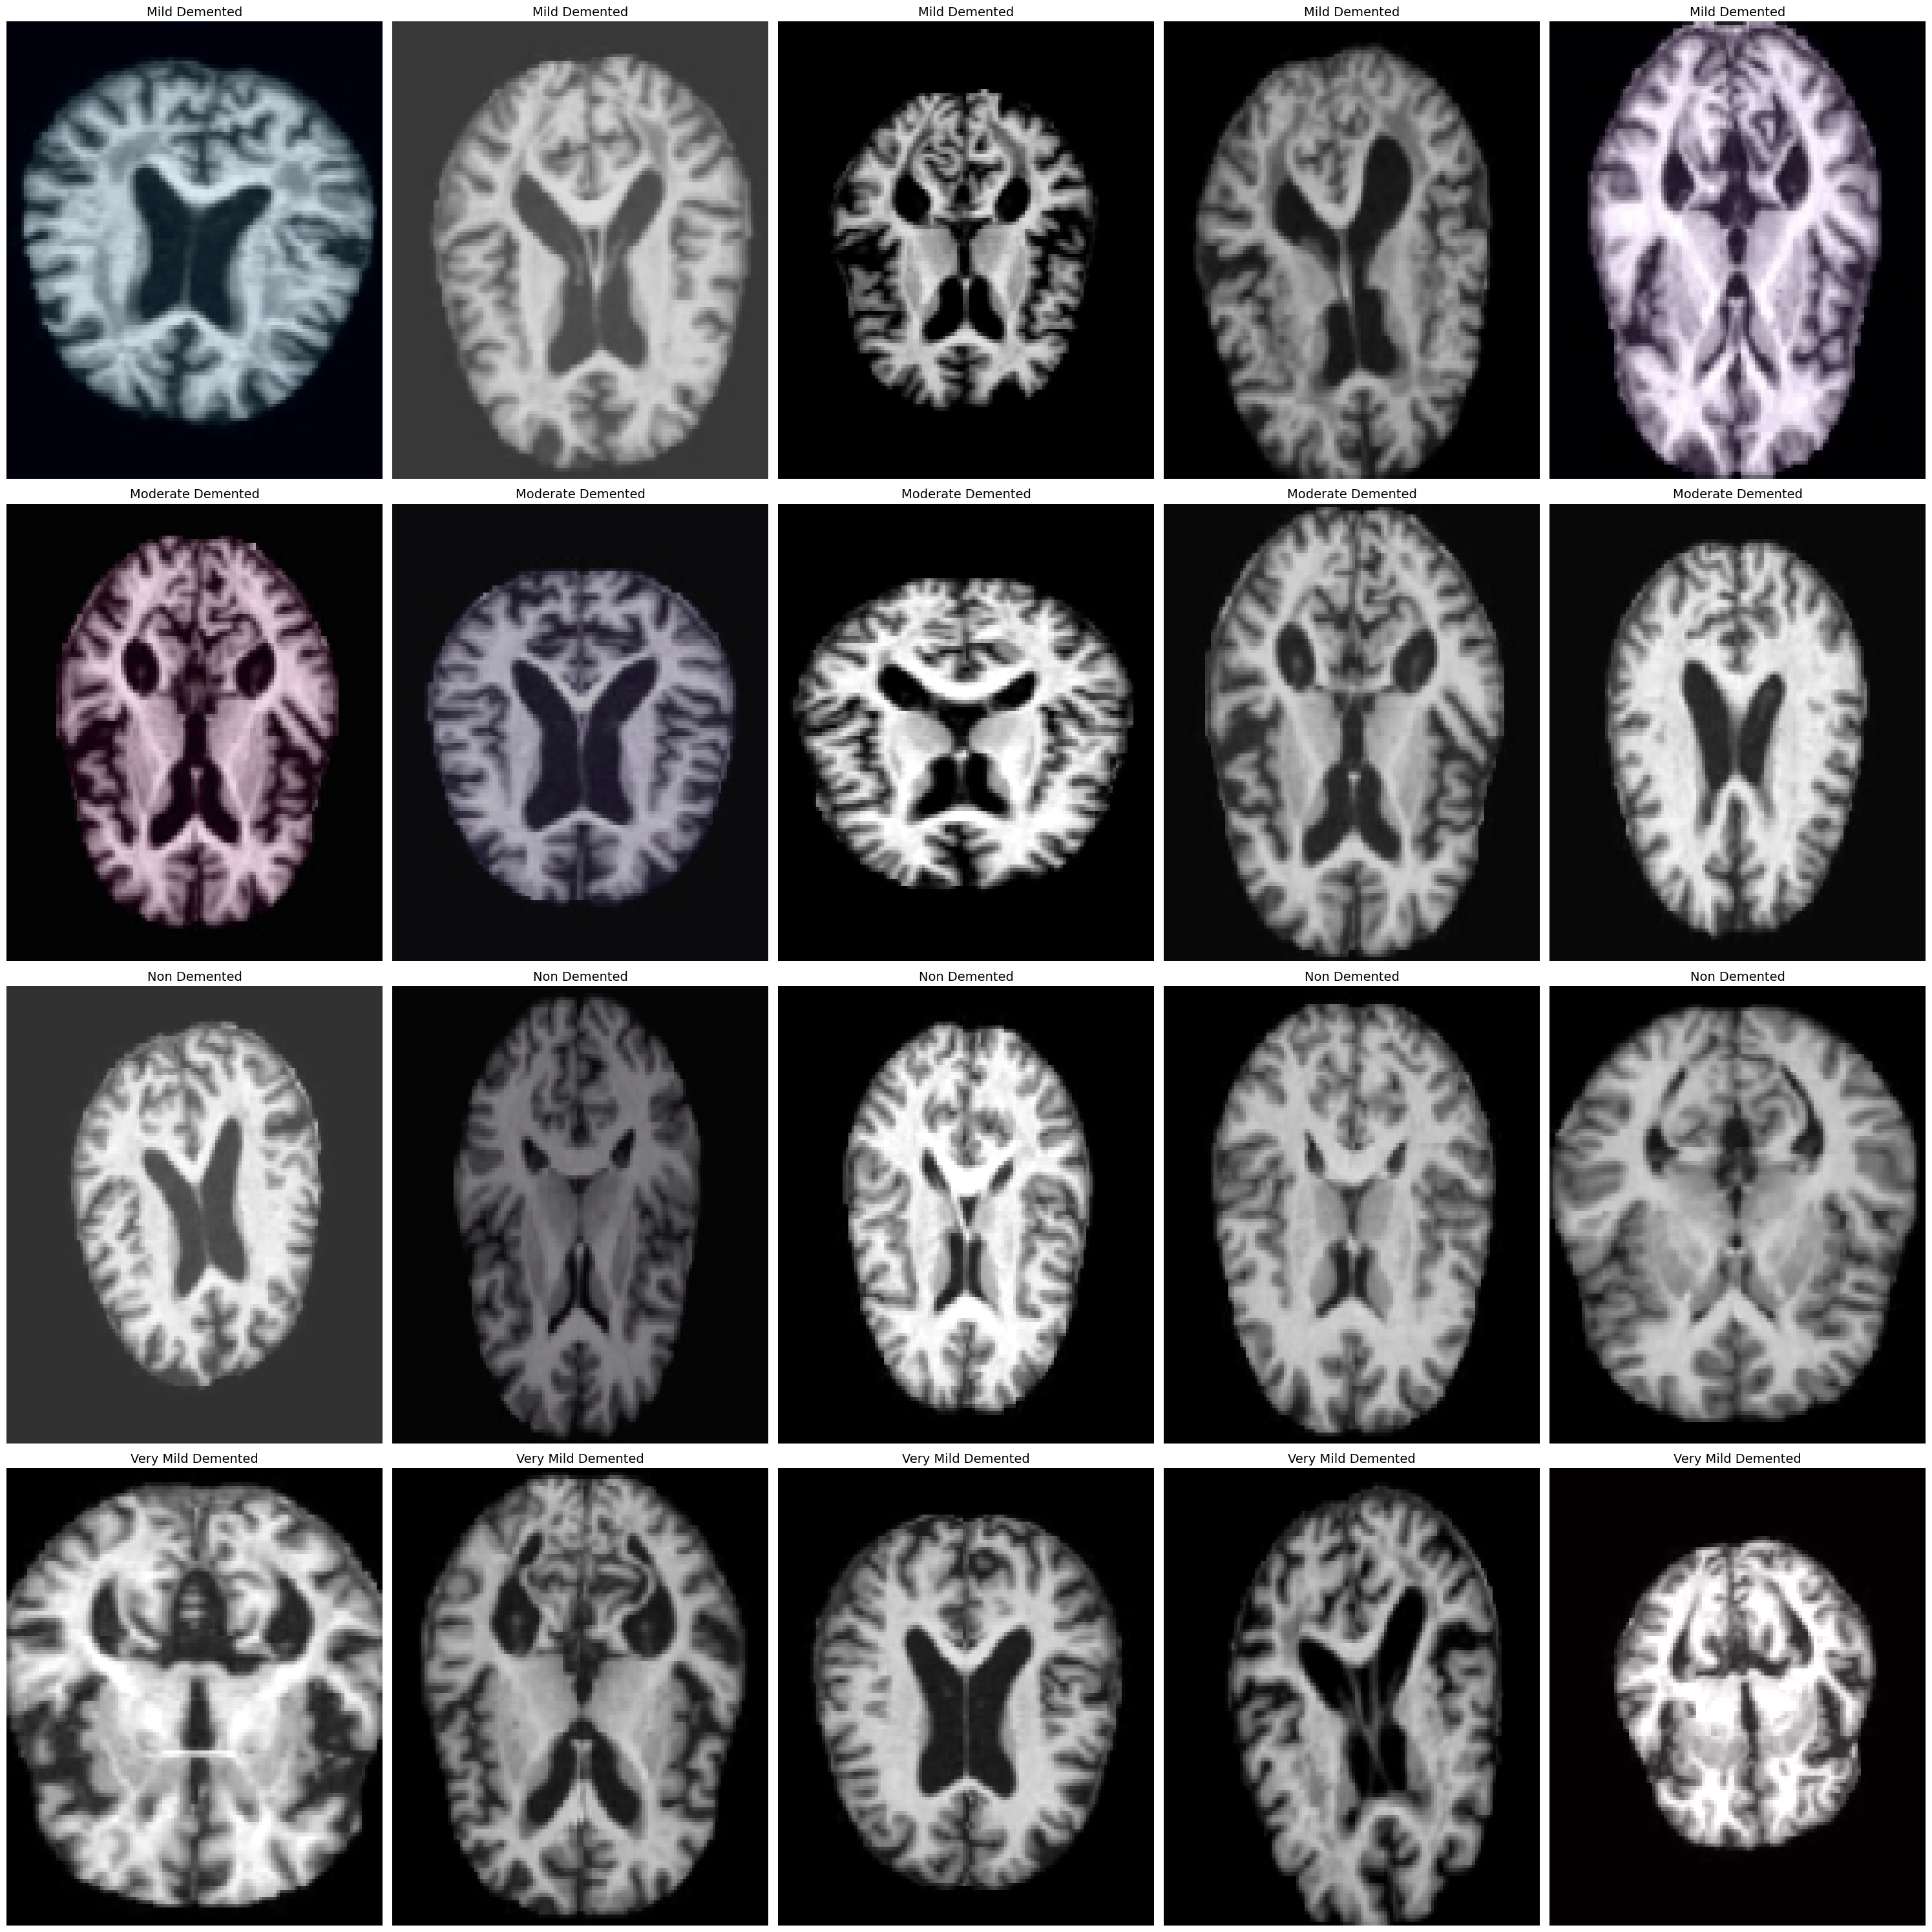

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np


# Define class labels
class_labels = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented"
}

# Number of images you want to display per class (5 images per class)
num_images_per_class = 5
total_classes = 4
total_images = num_images_per_class * total_classes

# To store images and labels
images_list = []
labels_list = []

# Loop over each class and extract 5 images from each class
for class_label in range(total_classes):
    class_images = []  # List to store images of the current class
    class_labels_batch = []  # List to store labels of the current class

    # Keep fetching batches until we get 5 images for the current class
    while len(class_images) < num_images_per_class:
        # Get a batch of images and labels
        images, labels = next(train_data)

        # Get the indices of the images that belong to the current class
        class_indices = np.where(labels == class_label)[0]

        # Add only the images and labels of the current class
        class_images.extend(images[class_indices])
        class_labels_batch.extend(labels[class_indices])

    # Append the selected images and labels to the list
    images_list.extend(class_images[:num_images_per_class])
    labels_list.extend(class_labels_batch[:num_images_per_class])

# Create a subplot grid for displaying the images
f, ax = plt.subplots(4, 5, figsize=(30, 30))  # 4 rows, 5 columns

# Loop through the collected images and display them
for i in range(total_images):
    img = images_list[i]  # Get the image from the list
    ax[i // 5, i % 5].imshow(img)  # Display image
    
    label = labels_list[i]  # Get the corresponding label
    label_text = class_labels[label]  # Convert label to text

    ax[i // 5, i % 5].set_title(label_text, fontsize=14)
    ax[i // 5, i % 5].axis('off')  # Hide axes
    ax[i // 5, i % 5].set_aspect('auto')

# Display the plot
plt.tight_layout()
plt.show()


# Step 3: Data Preprocessing and Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [9]:
# # Debugging the train generator output
# x_batch, y_batch = next(train_generator)
# print(f"Images batch shape: {x_batch.shape}")
# print(f"Labels batch shape: {y_batch.shape}")

sample_batch = next(iter(train_generator))
print(f"Images batch shape: {sample_batch[0].shape}")
print(f"Labels batch shape: {sample_batch[1].shape}")


Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 4)


In [17]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 4
Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


### Squeeze-and-Excitation (SE) Blocks are a type of architectural innovation introduced to enhance the performance of convolutional neural networks (CNNs). These blocks aim to recalibrate the feature maps generated by CNNs by emphasizing the most informative channels and suppressing less useful ones.

# Step 4: Define the SECNN Model with Squeeze-and-Excitation (SE) Blocks

In [14]:
# Get a single batch of data
batch = next(iter(train_generator))
images, labels = batch

# Print shapes and types
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Labels shape: {labels.shape}, dtype: {labels.dtype}")


Images shape: (32, 128, 128, 3), dtype: float32
Labels shape: (32, 4), dtype: float32


In [6]:
def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)

    # Excitation: Fully Connected layers with reduction ratio
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)

    # Scale: Multiply the channel-wise weights with the input feature map
    return layers.multiply([input_tensor, se])


# Step 5: Build the SECNN Model 

In [ ]:
# Build the SECNN model
def build_secnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)  # Add light dropout
    x = se_block(x)

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)  # Increase dropout
    x = se_block(x)

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)  # Increase dropout further
    x = se_block(x)

    # Fourth Convolutional Block
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)  # High dropout for regularization
    x = se_block(x)

    # Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation="relu")(x)  # Fully connected layer
    x = Dropout(0.4)(x)  # Final dropout layer
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Build the SECNN model
secnn_model = build_secnn((IMG_HEIGHT, IMG_WIDTH, 3), len(train_generator.class_indices))


In [7]:
# Compute class weights
class_labels = list(train_generator.class_indices.keys())  # Class labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")


Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


# Step 6: Compile the SECNN Model


In [38]:
secnn_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
# Check class indices
print(f"Class indices: {train_generator.class_indices}")
print(f"Number of classes: {len(train_generator.class_indices)}")

# Check model output shape
print(f"Model output shape: {secnn_model.output_shape}")


Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Number of classes: 4
Model output shape: (None, 4)


# Step 7: Define Callbacks (Early Stopping and ReduceLROnPlateau)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Step 8: Train the SECNN Model and Plot Training Graphs

100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 285ms/step - accuracy: 0.8624 - loss: 0.3387
Validation Accuracy: 80.41%


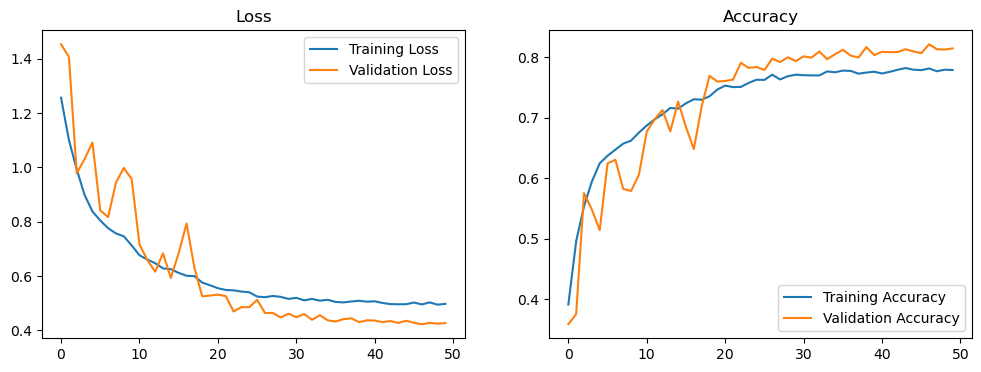

In [10]:

# Evaluate on validation set
val_loss, val_accuracy = secnn_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()


# Step 9: Feature Extraction with SECNN

In [26]:
# Feature extractor model to extract features before the final classification layer
feature_extractor = models.Model(inputs=secnn_model.input, outputs=secnn_model.layers[-2].output)

# Extract features from training and testing data
X_train_features = feature_extractor.predict(train_generator)
X_test_features = feature_extractor.predict(val_generator)



C:\Users\Krishna\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 190s 473ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 343ms/step


# Step 12: Evaluate the SECNN Model

In [46]:
# Step 4: Train a classifier on the extracted features (e.g., RandomForest)
rf_model = RandomForestClassifier()
rf_model.fit(X_train_features, train_generator.classes)  # Train on the extracted training features


RandomForestClassifier()

100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step
Test Accuracy of SECNN Model: 0.8113
Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.82      0.87      0.85       800
ModerateDemented       0.97      1.00      0.98       800
     NonDemented       0.81      0.68      0.74       800
VeryMildDemented       0.65      0.70      0.67       800

        accuracy                           0.81      3200
       macro avg       0.81      0.81      0.81      3200
    weighted avg       0.81      0.81      0.81      3200



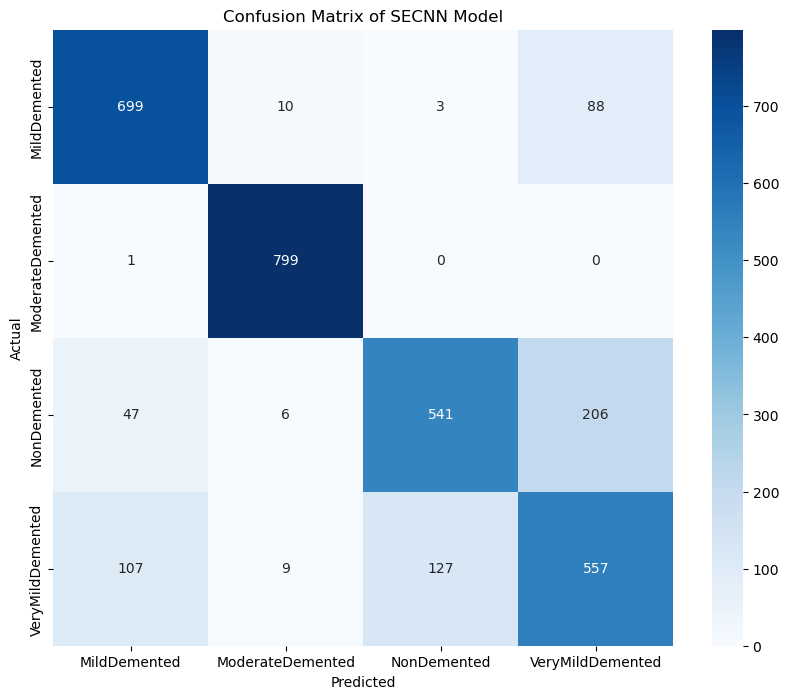

In [42]:
# Predict class probabilities
y_pred_prob = secnn_model.predict(val_generator)

# Convert probabilities to class indices (predicted labels)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels from the test generator
y_true = val_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy of SECNN Model: {accuracy:.4f}")

# Classification report
class_labels = list(val_generator.class_indices.keys())
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")z
plt.ylabel("Actual")
plt.title("Confusion Matrix of SECNN Model")
plt.show()


In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = secnn_model.evaluate(train_generator)
print(f"Training Accuracy: {val_accuracy * 100:.2f}%")

# Save and Predict

In [ ]:
# Save the trained model
secnn_model.save(r"C:\Users\Akshay\Downloads\mlp\mlp\secnn_model.h5")
print("Model saved to 'secnn_model.h5'")




Model saved to 'secnn_model.h5'


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
model_path =r"C:\Users\Akshay\Downloads\mlp\mlp\secnn_model.h5"
loaded_model = load_model(model_path)
print("Model loaded successfully!")
# Predict on a single image
class_labels = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

def predict_single_image(img_path, model):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class probabilities
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example prediction
img_path = r"C:\Users\Akshay\Downloads\mlp\balanced_dataset\NonDemented\0b8a5bb5-be5b-433e-9c0d-cc6de2c7a3b5.jpg"
predict_single_image(img_path, secnn_model)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Class: NonDemented


'NonDemented'

# Step : Prediction Function with Saliency Map Display

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Predicted Class: NonDemented
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


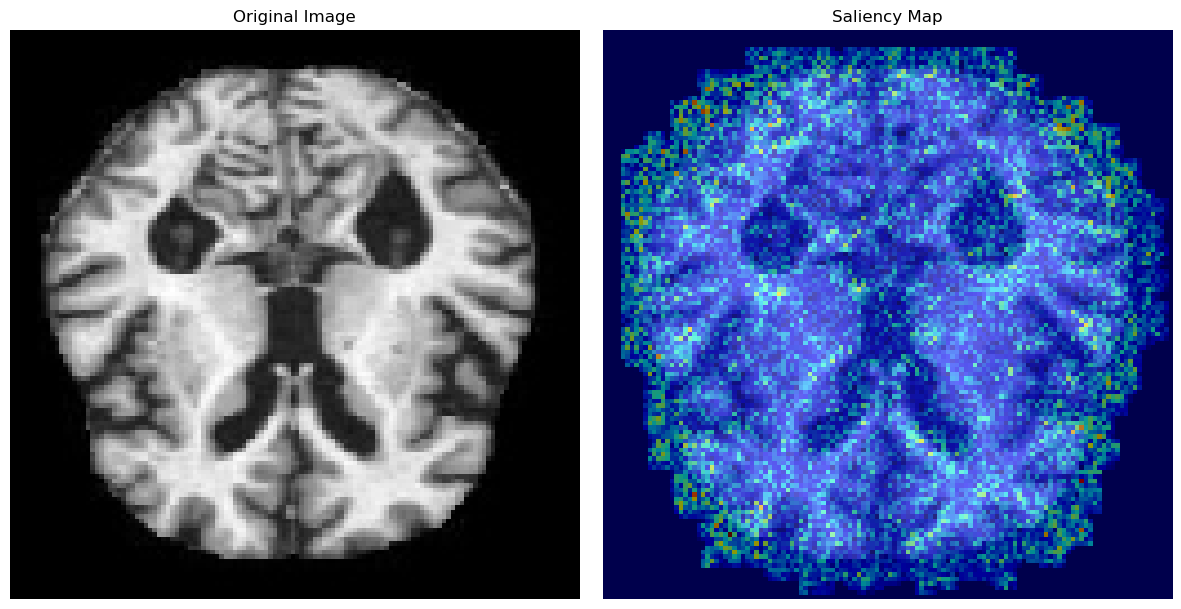

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load the SECNN model
model_path = r"C:\Users\Akshay\Downloads\mlp\mlp\secnn_model.h5"
secnn_model = load_model(model_path)
print("Model loaded successfully!")

# Class labels (ensure these match your training dataset)
class_labels = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
def predict_single_image(img_path, model):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class probabilities
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Example prediction
# img_path = r"C:\Users\Krishna\Downloads\mlp\AugmentedAlzheimerDataset\ModerateDemented\fee2b1ba-b9a7-44f0-80be-230c04796d4b.jpg"
# predict_single_image(img_path, secnn_model)

# Function to generate saliency map
def generate_saliency_map(model, img_array, class_index):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        predicted_class_score = predictions[:, class_index]
    grads = tape.gradient(predicted_class_score, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1).numpy()[0]
    return saliency_map

# Visualization function (no prediction output)
def visualize_image_with_saliency(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class probabilities (required for saliency map)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)

    # Generate the saliency map for the predicted class
    saliency_map = generate_saliency_map(model, img_array, predicted_class_index)

    # Display the original image and saliency map
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image.array_to_img(img_array[0]))
    plt.imshow(saliency_map, cmap='jet', alpha=0.6)
    plt.title("Saliency Map")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Test the function with an example image path
img_path = r"C:\Users\Akshay\Downloads\mlp\balanced_dataset\NonDemented\0b8a5bb5-be5b-433e-9c0d-cc6de2c7a3b5.jpg"
predict_single_image(img_path, secnn_model)
visualize_image_with_saliency(img_path, secnn_model)


### A saliency map is a visual representation that highlights the most important regions in an input image that influence a model's decision. It helps us understand why a model made a particular prediction by showing which parts of the image had the greatest impact on the model's output.

